In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import torch.nn.functional as F
from time import time



from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from IPython.display import clear_output
from torch.optim import lr_scheduler
%matplotlib inline


%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

### Generator

https://arxiv.org/pdf/1609.04802.pdf


> ![SRGAN Generator](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/SRGAN-Generator.png?raw=true)


In [3]:
class Shuffle_Block(nn.Module):
  def __init__(self, channels = 64):
    super().__init__()
    self.block = nn.Sequential(
        nn.Conv2d(in_channels = channels, out_channels =4*channels, kernel_size = 3, stride = 1, padding = 1),
        nn.PixelShuffle(upscale_factor = 2),
        nn.PReLU()
    )

  def forward(self, x):
    return self.block(x) # [B, channels, W*2, H*2]

In [4]:
class Residual_Block(nn.Module):
  def __init__(self, channels = 64):
    super().__init__()
    self.block = nn.Sequential(
       nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, stride = 1, padding = 1),
       nn.BatchNorm2d(num_features = channels),
       nn.PReLU(),

       nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, stride = 1, padding = 1),
       nn.BatchNorm2d(num_features = channels),
    )

  def forward(self, x):
    return x+self.block(x) # elementwise summ

In [5]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Generator(nn.Module):
  def __init__(self, channels = 64, num_residual_blocks = 10, num_shuffle_blocks = 2 ):
    super().__init__()

    self.in_layer = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = channels, kernel_size = 9, stride = 1, padding = 4),
        nn.PReLU(),
    )

    self.mid_layer = nn.Sequential(
        nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(channels)
    )

    self.end_layer = nn.Sequential(
        nn.Conv2d(in_channels = channels, out_channels = 3, kernel_size = 9, stride = 1, padding = 4),
        nn.Tanh()
    )
    
    self.residual_blocks = []
    for _ in range(num_residual_blocks):
      self.residual_blocks+=[Residual_Block(channels = channels)]
    
    self.shuffle_blocks = []
    for _ in range(num_shuffle_blocks):
      self.shuffle_blocks+=[Shuffle_Block(channels = channels)]

    self.residual_blocks = nn.Sequential(*self.residual_blocks)
    self.shuffle_blocks = nn.Sequential(*self.shuffle_blocks)


  def forward(self, x):
    x = self.in_layer(x)
    x = x + self.residual_blocks(x)
    x = self.shuffle_blocks(x)
    return self.end_layer(x)


### Discriminator


![SRGAN Generator](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/SRGAN-Discriminator.png?raw=true)




In [6]:
class Convolution_Blocks(nn.Module):
  def __init__(self, channels):
    super().__init__()

    self.block = nn.Sequential(
        nn.Conv2d(in_channels = channels, out_channels = 2*channels, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(2*channels),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels = 2*channels, out_channels = 2*channels, kernel_size = 3, stride = 2, padding = 1),
        nn.BatchNorm2d(2*channels),
        nn.LeakyReLU(0.2, inplace=True),
    )

  def forward(self, x):
      return self.block(x)

In [7]:
4*64*16

4096

In [8]:
class Discriminator(nn.Module):
  def __init__(self, channels = 64, num_conv_blocks = 3):
    super().__init__()

    self.int_layer = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = channels, kernel_size = 3, stride = 1),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, stride = 2),
        nn.BatchNorm2d(channels),
        nn.LeakyReLU(0.2, inplace=True)
    )

    self.end_layer = nn.Sequential(
        nn.AdaptiveAvgPool2d(2),
        nn.Flatten(),
        nn.Linear(in_features= channels*2**num_conv_blocks*2*2, out_features = 1024),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(in_features = 1024, out_features = 1),
        nn.Sigmoid()
        )
    

    self.conv_blocks = []
    for i in range(num_conv_blocks):
      self.conv_blocks+=[Convolution_Blocks(channels*2**(i))]  # 64-> 128, 128->256, 256->512 if num_conv_blocks==3
    
    self.conv_blocks = nn.Sequential(*self.conv_blocks)

    
 
  def forward(self, x):
    x = self.int_layer(x)
    x = self.conv_blocks(x)
    x = self.end_layer(x)
    
    return x

### Loss function

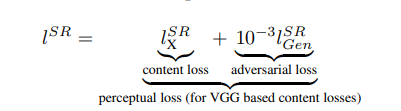  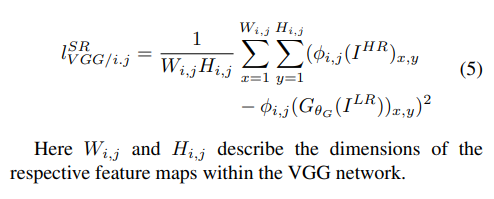

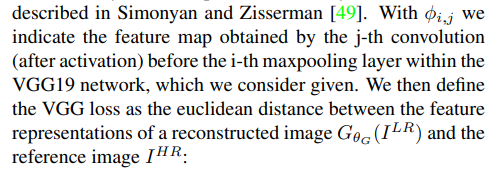

In [9]:
from torchvision.models import vgg19, VGG19_Weights
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

In [10]:
class Content_loss(nn.Module):
  def __init__(self):
    super().__init__()

    weights= VGG19_Weights.IMAGENET1K_V1
    self.VGG = vgg19(weights= weights)
    self.nodes = {'features.8':'features.8'}   # after 2 conv (after activation) and 2 second maxpool
    self.VGG = create_feature_extractor(self.VGG, return_nodes=self.nodes).to(device).eval()
    for param in self.VGG.parameters():
      param.requires_grad = False

  def forward(self, x_fake, x_true):
    return F.mse_loss(self.VGG(x_fake)['features.8'], self.VGG(x_true)['features.8']) #2 4 


In [11]:
#F.mse_loss(self.VGG(x_fake)['features.5'], self.VGG(x_true)['features.5'])

In [12]:
class Adversarial_loss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, prob_vec, targ: bool):
    if targ:
      return F.binary_cross_entropy(prob_vec,torch.ones_like(prob_vec, device=device))
    else:
      return F.binary_cross_entropy(prob_vec,torch.zeros_like(prob_vec, device=device))

In [13]:
class MSE(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x_fake, x_true):
    return F.mse_loss(x_fake, x_true) #2 4 

### Data loader creating


In [14]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [15]:
from torchvision.transforms import InterpolationMode

In [37]:
from torch.utils.data.dataset import Dataset
class DIV2K_bicubic(Dataset):
  def __init__(self, lr_image_size= 64, train= True):
    if train:
      self.DIR2= Path('/content/train')
      if self.DIR2.exists()==False:
        from google.colab import drive
        drive.mount('/content/gdrive/')
        !unzip -q /content/gdrive/MyDrive/data/DIV2K/full2k.zip
    else:
      self.DIR2= Path('/content/test')
      if self.DIR2.exists()==False:
        from google.colab import drive
        drive.mount('/content/gdrive/')

    self.size= lr_image_size
    self.hr_transforms = tt.Compose([
            tt.RandomCrop((lr_image_size*4,lr_image_size*4)),
            tt.RandomHorizontalFlip(),
            tt.ToTensor(),
            tt.ConvertImageDtype(torch.float), #-> [0,1]
            tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #->[-1,1]
        ])

    self.lr_transforms = tt.Compose([
            tt.Normalize((-1.0, -1.0, -1.0), (2.0, 2.0, 2.0)), #->[0,1]
            tt.ToPILImage(),
            tt.Resize((lr_image_size,lr_image_size), InterpolationMode.BICUBIC),
            tt.ToTensor(),
        ])

    self.hr= list((self.DIR2.rglob('*.png')))

  def __len__(self):
    return len(self.hr)

  def __getitem__(self, idx):

    self.lr_transforms = tt.Compose([
            tt.Normalize((-1.0, -1.0, -1.0), (2.0, 2.0, 2.0)), #->[0,1]
            tt.ToPILImage(),
            tt.Resize((self.size,self.size),np.random.choice([InterpolationMode.BILINEAR, InterpolationMode.BICUBIC])),
            tt.ToTensor(),
        ])
    
    hr= self.hr_transforms(Image.open(self.hr[idx]))
    lr= self.lr_transforms(hr)
    return lr, hr

### Generator training

In [17]:
#torch.save(model.state_dict(), PATH)

#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()

In [18]:
device= 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [47]:
max_epoch= 10
lr= 1E-5
model= Generator(channels= 64, num_residual_blocks= 16, num_shuffle_blocks= 2).to(device)
model.load_state_dict(torch.load('/content/generator_16_vesov_vgg4.pt'))
# vgg has 256*256 input size, our network should to has in 4 pown less  256/4 = 64
train_data_loader=  DataLoader(DIV2K_bicubic(lr_image_size= 64, train= True), batch_size= 16, shuffle= True, pin_memory= True, drop_last= True, )
val_data_loader= DataLoader(DIV2K_bicubic(lr_image_size= 64, train= False), batch_size= 16, shuffle= True, pin_memory= True, drop_last= True)

criterion= Content_loss()
optimizer= torch.optim.Adam(model.parameters(), lr= lr)
scheduler= torch.optim.lr_scheduler.MultiStepLR(optimizer, [int(max_epoch*1/1)], gamma= 0.1)

In [27]:
DIR2= Path('/content/train')
trans= tt.ToTensor()
[os.remove(file) for file in list((DIR2.rglob('*.png'))) if trans(Image.open(file)).shape[0]<3 or trans(Image.open(file)).shape[1]<256 or trans(Image.open(file)).shape[2]<256]

[None, None]

In [43]:
def generator_train(model, train_data_loader, val_data_loader, criterion, max_epoch, optimizer, scheduler):
  val_history_loss= []
  train_history_loss= []

  for epoch in range(max_epoch):
    train_loss= 0
    train_batch_nums= 0

    val_loss= 0
    val_batch_nums= 0

    model.train()
    for x_lr_batch, x_hr_batch in train_data_loader:
      optimizer.zero_grad()
      loss= criterion(model(x_lr_batch.to(device)), x_hr_batch.to(device))
      loss.backward()
      optimizer.step()

      train_batch_nums+=1
      train_loss+=loss.to('cpu')
    scheduler.step()
    train_history_loss.append(train_loss/train_batch_nums)

    model.eval()
    clear_output(wait= True)
    with torch.no_grad():
      if epoch+1 % 10 ==0:
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/data/DIV2K{0}.pt'.format(epoch+1))

      for x_lr_batch, x_hr_batch in val_data_loader:
        x_lr_batch= model(x_lr_batch.to(device))
        loss= criterion(x_lr_batch, x_hr_batch.to(device))
        val_batch_nums+=1
        val_loss+=loss.to('cpu')

      val_history_loss.append(val_loss/val_batch_nums)
      
      

      fig, ax = plt.subplots(figsize=(12,8))
      ax.plot(np.arange(0,epoch+1,1), train_history_loss[0:])
      ax.plot(np.arange(0,epoch+1,1), val_history_loss[0:])
      plt.show()

      print("Epoch [{}/{}]".format(epoch+1, max_epoch))
      fig, ax = plt.subplots(nrows= 4, ncols= 2, figsize=(10,18), sharey=True, sharex=True)
      for i in range(4):
        ax[i,0].imshow(((x_lr_batch[i].to('cpu').permute(1,2,0)+1)/2))
        ax[i,1].imshow(((x_hr_batch[i].to('cpu').permute(1,2,0)+1)/2))
        ax[i,0].grid(False)
        ax[i,1].grid(False)
      plt.show()
      print("Epoch [{}/{}]".format(epoch+1, max_epoch))
      

    

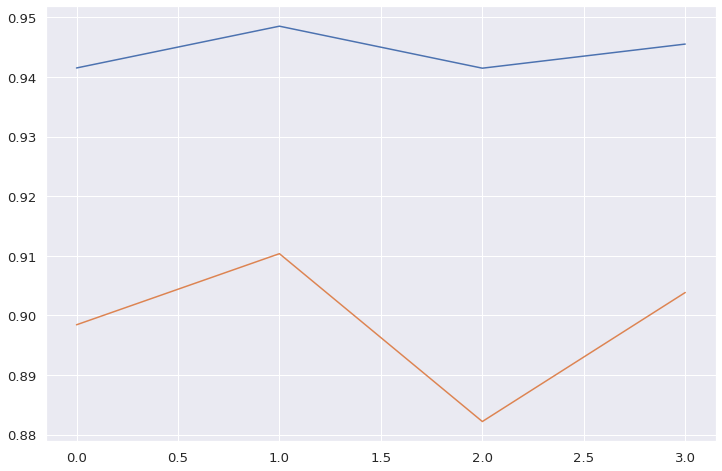

Epoch [4/10]


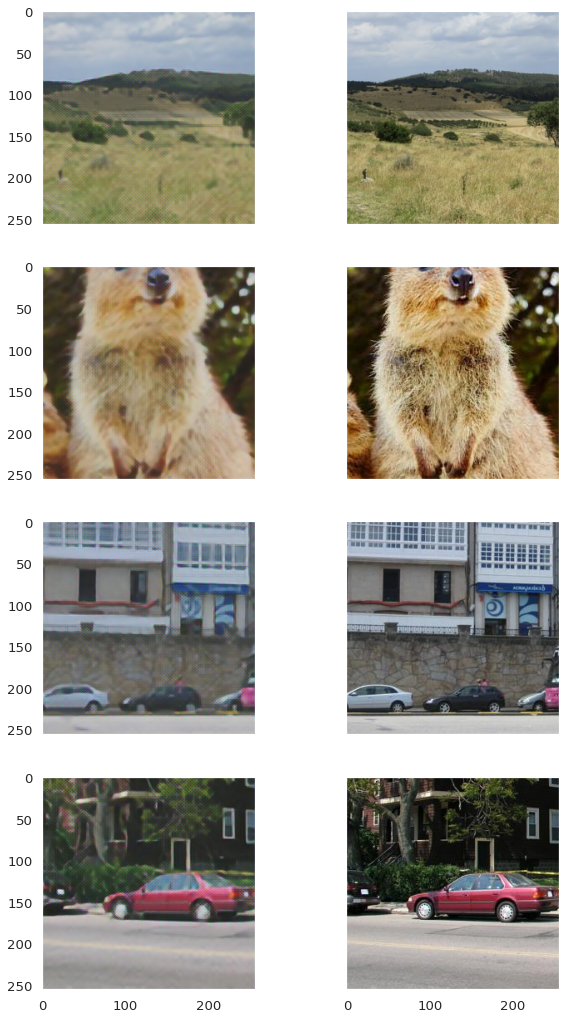

Epoch [4/10]


KeyboardInterrupt: ignored

In [48]:
#if Path('/content/generator_16_vesov_vgg80_566.0.pt').exists() ==False:
generator_train(model, train_data_loader, val_data_loader, criterion, max_epoch, optimizer, scheduler)

In [49]:
torch.save(model.state_dict(), '/content/generator_16_vesov_vgg4.pt')

In [197]:
#model.load_state_dict(torch.load('/content/trained_generator/generator2.pt'))
#model.eval()

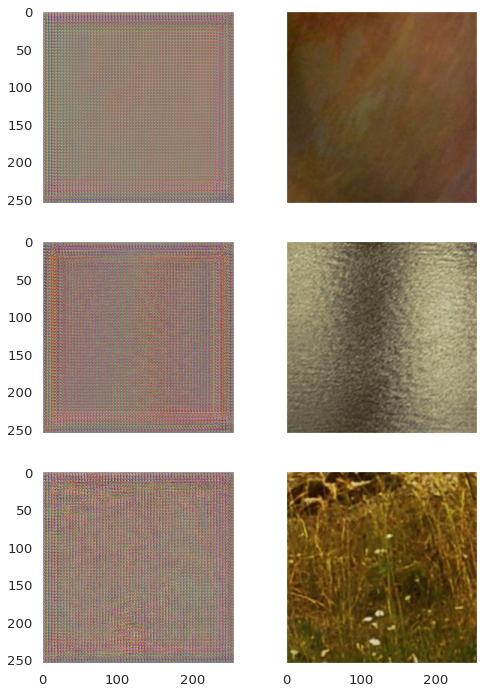

In [198]:
with torch.no_grad():
      for x_lr_batch, x_hr_batch in val_data_loader:
        x_lr_batch= model(x_lr_batch.to(device))
        break

      fig, ax = plt.subplots(nrows= 3, ncols= 2, figsize=(8,12), sharey=True, sharex=True)
      for i in range(3):
        ax[i,0].imshow((x_lr_batch[i].to('cpu').permute(1,2,0)+1)/2)
        ax[i,1].imshow((x_hr_batch[i].to('cpu').permute(1,2,0)+1)/2)
        ax[i,0].grid(False)
        ax[i,1].grid(False)
      plt.show()

### Обучение RSGAN

In [55]:
def RSGAN_train(model, train_data_loader, val_data_loader,criterion, max_epoch, optimizer, scheduler, k_adv, k_mse):
  val_history_loss_gen= []
  val_history_loss_dic= []
  train_history_loss_gen= []
  train_history_loss_dic= []
  z= 1
  for epoch in range(max_epoch):
    train_loss_gen= 0
    train_loss_dis= 0
    train_batch_nums= 0

    val_loss_gen= 0
    val_loss_dis= 0
    val_batch_nums= 0
  
    model['generator'].train()
    model['discriminator'].train()
    for x_lr_batch, x_hr_batch in train_data_loader:
      #'discriminator' train
      x_lr_batch= x_lr_batch.to(device)
      x_hr_batch= x_hr_batch.to(device)
      
      optimizer['generator'].zero_grad()
      optimizer['discriminator'].zero_grad()
      loss= criterion['adversarial'](model['discriminator'](model['generator'](x_lr_batch)), False)+criterion['adversarial'](model['discriminator'](x_hr_batch), True)
      loss.backward()
      optimizer['discriminator'].step()
      train_loss_dis+=loss.to('cpu')/z

      

      #generator train
      optimizer['generator'].zero_grad()
      optimizer['discriminator'].zero_grad()
      x_lr_batch= model['generator'](x_lr_batch)
      loss= k_adv*(criterion['adversarial'](model['discriminator'](x_lr_batch), True)+criterion['adversarial'](model['discriminator'](x_hr_batch), True))+\
      criterion['content'](x_lr_batch, x_hr_batch)#+k_mse*criterion['mse'](x_lr_batch, x_hr_batch)
      loss.backward()
      optimizer['generator'].step()
      train_loss_gen+=loss.to('cpu')

      train_batch_nums+=1

    scheduler['generator'].step()
    scheduler['discriminator'].step()

    train_history_loss_gen.append(train_loss_gen/train_batch_nums)
    train_history_loss_dic.append(train_loss_dis/train_batch_nums)

    model['generator'].eval()
    model['discriminator'].eval()
    clear_output(wait= True)
    with torch.no_grad():
      if epoch+1 % 5 ==0:
        torch.save(model['discriminator'].cpu().state_dict(), '/content/gdrive/MyDrive/data/DIV2K/predtrained/SRdiscriminator_v2_{0}_{1}.pt'.format(epoch,time()//100%100))
        torch.save(model['generator'].cpu().state_dict(), '/content/gdrive/MyDrive/data/DIV2K/predtrained/SRgenerator_v2_{0}_{1}.pt'.format(epoch,time()//100%100))
        model['generator'].to(device)
        model['discriminator'].to(device)
      
      for x_lr_batch, x_hr_batch in val_data_loader:
        x_lr_batch = x_lr_batch.to(device)
        x_hr_batch= x_hr_batch.to(device)
        x_lr_batch= model['generator'](x_lr_batch)#!!!

        loss= (criterion['adversarial'](model['discriminator'](x_lr_batch), False)+criterion['adversarial'](model['discriminator'](x_hr_batch), True))
        val_loss_dis+=loss.to('cpu')/z


        loss= criterion['content'](x_lr_batch, x_hr_batch)#+k_mse*criterion['mse'](x_lr_batch, x_hr_batch)
        loss+= k_adv*(criterion['adversarial'](model['discriminator'](x_lr_batch), True)+criterion['adversarial'](model['discriminator'](x_hr_batch), True))
        val_loss_gen+=loss.to('cpu')



        val_batch_nums+=1

      val_history_loss_gen.append(val_loss_gen/val_batch_nums)
      val_history_loss_dic.append(val_loss_dis/val_batch_nums)
      

      fig, ax = plt.subplots(figsize=(10,6))
      ax.set_title('train')
      ax.plot(np.arange(0,epoch+1,1), train_history_loss_gen[0:])
      ax.plot(np.arange(0,epoch+1,1), train_history_loss_dic[0:])
      plt.legend(('generator','discriminator/{}'.format(z)))
      plt.show()


      fig, ax = plt.subplots(figsize=(10,6))
      ax.set_title('val')
      ax.plot(np.arange(0,epoch+1,1),  val_history_loss_gen[0:])
      ax.plot(np.arange(0,epoch+1,1), val_history_loss_dic[0:])
      plt.legend(('generator','discriminator/{}'.format(z)))
      plt.show()

      print("Epoch [{}/{}]".format(epoch+1, max_epoch))
      fig, ax = plt.subplots(nrows= 3, ncols= 2, figsize=(8,12), sharey=True, sharex=True)
      for i in range(3):
        ax[i,0].imshow((x_lr_batch[i].to('cpu').permute(1,2,0)+1)/2)
        ax[i,1].imshow((x_hr_batch[i].to('cpu').permute(1,2,0)+1)/2)
        ax[i,0].grid(False)
        ax[i,1].grid(False)
      plt.show()
      

In [200]:
device= 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [56]:
from torch.nn.modules.loss import MSELoss
model1= Generator(channels= 64, num_residual_blocks= 16, num_shuffle_blocks= 2)
model1.load_state_dict(torch.load('/content/generator_16_vesov_vgg4.pt'))

model2= Discriminator(channels= 64, num_conv_blocks= 3)
#model2.load_state_dict(torch.load('/content/SRdiscriminator_v3.pt'))


max_epoch =40
lr1, lr2= 1E-4, 1E-4

model1= model1.to(device)
model2= model2.to(device)
model_RSGAN={
    'discriminator': model2,
    'generator': model1
}
criterion= {
    'adversarial': Adversarial_loss(),
    'content': Content_loss(),
    'mse': MSELoss()
}

train_data_loader=  DataLoader(DIV2K_bicubic(lr_image_size= 64, train= True), batch_size= 16, shuffle= True, pin_memory= True, drop_last= True, )
val_data_loader= DataLoader(DIV2K_bicubic(lr_image_size= 64, train= False), batch_size= 16, shuffle= True, pin_memory= True, drop_last= True)

optimizer= {
   'generator': torch.optim.Adam(model_RSGAN['generator'].parameters(), lr= lr2),
   'discriminator': torch.optim.Adam(model_RSGAN['discriminator'].parameters(), lr= lr1),
}

scheduler= {
    'discriminator': torch.optim.lr_scheduler.MultiStepLR(optimizer['discriminator'], [800], gamma= 0.1),
    'generator': torch.optim.lr_scheduler.MultiStepLR(optimizer['generator'], [800], gamma= 0.1)
}

In [202]:
#tensor(0.0481, device='cuda:0', grad_fn=<MseLossBackward0>) mse
#tensor(0.9517, device='cuda:0', grad_fn=<MseLossBackward0>) comt
#tensor(2.1437, device='cuda:0', grad_fn=<AddBackward0>) adv

In [203]:
#tensor(0.1008, device='cuda:0', grad_fn=<MseLossBackward0>)
#tensor(0.7160, device='cuda:0', grad_fn=<MseLossBackward0>)
#tensor(6.8602, device='cuda:0', grad_fn=<AddBackward0>)

имеем mse=1/10 cont, adv=10^-3 cont

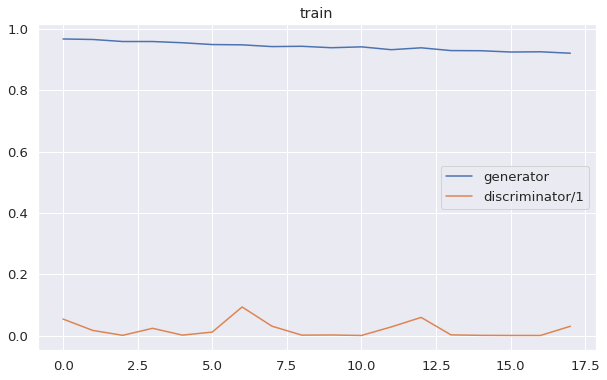

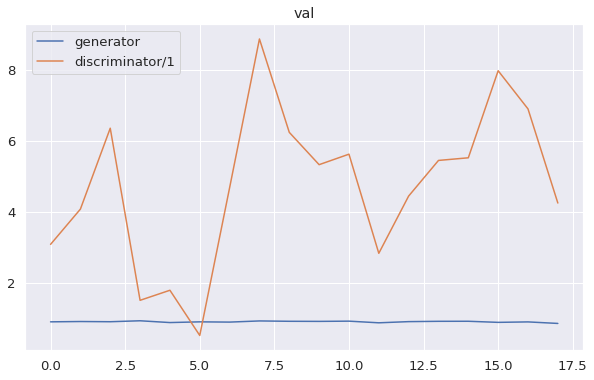

Epoch [18/40]


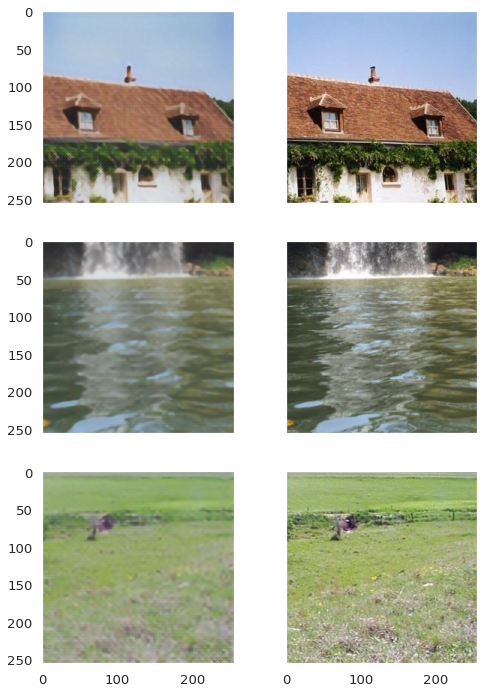

In [ ]:
RSGAN_train(model_RSGAN, train_data_loader, val_data_loader,criterion, max_epoch, optimizer, scheduler, 0.001,0)

adv, cont, mse

tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.8436, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4307, device='cuda:0', grad_fn=<MseLossBackward0>)


tensor(0.0133, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8757, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0718, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
torch.save(model_RSGAN['discriminator'].cpu().state_dict(), '/content/SRdiscriminator_v3.pt')
torch.save(model_RSGAN['generator'].cpu().state_dict(), '/content/SRgenerator_v3.pt')
        

In [ ]:
torch.save(model_RSGAN['discriminator'].cpu(), '/content/model_SRdiscriminator_v3.pt')
torch.save(model_RSGAN['generator'].cpu(), '/content/model_SRgenerator_v3.pt')
        

In [ ]:
if True:  
  model1= Generator(channels= 64, num_residual_blocks= 16, num_shuffle_blocks= 2)
  model1.load_state_dict(torch.load('/content/SRgenerator_v3.pt'))

  model2= Discriminator(channels= 64, num_conv_blocks= 3)
  model2.load_state_dict(torch.load('/content/SRdiscriminator_v3.pt'))
  model_RSGAN={
      'discriminator': model2,
      'generator': model1
  }

  with torch.no_grad():
        for x_lr_batch, x_hr_batch in val_data_loader:
          x_lr_batch= model_RSGAN['generator'].to(device)(x_lr_batch.to(device))
          break

        fig, ax = plt.subplots(nrows= 5, ncols= 2, figsize=(10,40), sharey=True, sharex=True)
        for i in range(5):
          ax[i,0].imshow((x_lr_batch[i].to('cpu').permute(1,2,0)+1)/2)
          ax[i,1].imshow((x_hr_batch[i].to('cpu').permute(1,2,0)+1)/2)
          ax[i,0].grid(False)
          ax[i,1].grid(False)
        plt.show()

In [ ]:
torch.save(model_RSGAN['discriminator'].cpu().state_dict(), '/content/gdrive/MyDrive/data/DIV2K/predtrained/0.0002,10/SRdiscriminator{0}_{1}.pt'.format(20,time()//10%1000))
torch.save(model_RSGAN['generator'].cpu().state_dict(), '/content/gdrive/MyDrive/data/DIV2K/predtrained/0.0002,10/SRgenerator{0}_{1}.pt'.format(20,time()//10%1000))

In [ ]:
torch.save(model_RSGAN['discriminator'].cpu(), '/content/SRgenerator{0}_{1}.pt'.format(140,time()//10%1000))
torch.save(model_RSGAN['generator'].cpu(), '/content/SRdiscriminator{0}_{1}.pt'.format(140,time()//10%1000))